In [1]:
%reload_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


2025-01-31 10:15:54.333523: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-31 10:15:54.406537: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-31 10:15:54.406575: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-31 10:15:54.419954: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-31 10:15:54.444510: I tensorflow/core/platform/cpu_feature_guar

Number of batches of 32 images train_ds: 250
Number of batches of 32 images validation_ds: 32
Number of batches of 32 images test_ds: 32


2025-01-31 10:15:57.521780: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error


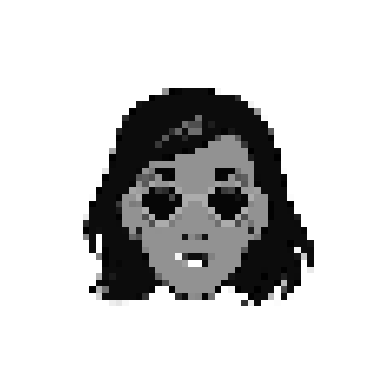

In [2]:
%run "../generacion_cartoon/data/0.1-drac-make_dataset.ipynb"
import generacion_cartoon.utils.paths as path
import notebooks.drac_CNVAE_gradient as CNVAE
import generacion_cartoon.visualization.visualize_CNVAE as visualize 
import tensorflow as tf
import time
import numpy as np

In [3]:
print("GPUs available:", len(tf.config.list_physical_devices('GPU')))

GPUs available: 0


In [4]:
import mlflow
import dagshub

In [5]:
params ={'latent_dim':90,
 'epochs':500,
 'epsilon':0.001,
 'alpha':1.0, #reconstruction_loss
 'beta':0.1,  #grad_decoded_loss
 'gamma':1.0} #center_loss


model = CNVAE.CNVAE(latent_dim=params['latent_dim'], alpha=params['alpha'],beta=params['beta'],gamma=params['gamma'])

In [6]:
name_model = f'model_FCNVAE__dim{params["latent_dim"]}_epocs={params["epochs"]}_epsilon={params["epsilon"]}_alpha={params["alpha"]}_beta={params["beta"]}_gamma={params["gamma"]}.weights.h5'
path_models = path.models_dir(name_model)

In [7]:
dagshub.init(repo_owner='DRACDARKTIME', repo_name='VA_cartoon', mlflow=True)
mlflow.set_experiment("FCNVAE_dim_alpha_beta_gamma")
mlflow.start_run()
mlflow.log_params(params)

optimizer = tf.keras.optimizers.Adam(params['epsilon'])

model.compile(params=params,
                    train_ds = train_ds,
                    test_ds=test_ds,
                    patience=100,
                    optimizer=optimizer,
                    path_models=path_models)

mlflow.tensorflow.log_model(model, 'model')        
mlflow.end_run()
name_gif = f'grid_CNVAE_epochs={params["epochs"]}_epsilon{params["epsilon"]}_alpha={params["alpha"]}_beta{params["beta"]}_gamma{params["gamma"]}.gif'
#visualize.create_gif(name_gif=name_gif, path_save_gif=path.data_created_dir('cnvae'))


Accessing as DRACDARKTIME

Initialized MLflow to track repo "DRACDARKTIME/VA_cartoon"

Repository DRACDARKTIME/VA_cartoon initialized!

2025-01-28 16:15:13.434579: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8901


Best model saved with best ELBO: 530.32 in epoch: 1
Epoch: 1, total_loss_train: 672.18, recons_loss_train: 653.58, grad_loss_train: 84.55, center_loss_train: 10.14
Epoch: 1, Test total_loss: 530.32, recons_loss: 510.10, grad_loss: 136.34, center_loss: 6.58, time_epoch: 16.96
Best model saved with best ELBO: 488.48 in epoch: 2
Epoch: 2, total_loss_train: 509.32, recons_loss_train: 491.31, grad_loss_train: 113.98, center_loss_train: 6.61
Epoch: 2, Test total_loss: 488.48, recons_loss: 472.26, grad_loss: 107.81, center_loss: 5.44, time_epoch: 14.11
Best model saved with best ELBO: 474.02 in epoch: 3
Epoch: 3, total_loss_train: 485.35, recons_loss_train: 470.45, grad_loss_train: 94.57, center_loss_train: 5.44
Epoch: 3, Test total_loss: 474.02, recons_loss: 460.15, grad_loss: 88.11, center_loss: 5.06, time_epoch: 14.14
Best model saved with best ELBO: 466.07 in epoch: 4
Epoch: 4, total_loss_train: 474.31, recons_loss_train: 460.46, grad_loss_train: 86.24, center_loss_train: 5.23
Epoch: 4, T

KeyboardInterrupt: 

In [8]:
  mlflow.end_run()

2025/01/28 17:18:10 INFO mlflow.tracking._tracking_service.client: 🏃 View run omniscient-wasp-92 at: https://dagshub.com/DRACDARKTIME/VA_cartoon.mlflow/#/experiments/9/runs/068b77b36e754472adbd042069a6453b.
2025/01/28 17:18:10 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/DRACDARKTIME/VA_cartoon.mlflow/#/experiments/9.


In [23]:
for dim in [20,30,40,50]:
    params ={'latent_dim':dim,
 'epochs':600,
 'epsilon':0.001,
 'alpha':1.0, #reconstruction_loss
 'beta':0.1,  #grad_decoded_loss
 'gamma':1.0} #center_loss


    model = CNVAE.CNVAE(latent_dim=params['latent_dim'], alpha=params['alpha'],beta=params['beta'],gamma=params['gamma'])
    name_model = f'model_CNVAE__dim{params["latent_dim"]}_epocs={params["epochs"]}_epsilon={params["epsilon"]}_alpha={params["alpha"]}_beta={params["beta"]}_gamma={params["gamma"]}.weights.h5'
    path_models = path.models_dir(name_model)
    dagshub.init(repo_owner='DRACDARKTIME', repo_name='VA_cartoon', mlflow=True)
    mlflow.set_experiment("CNVAE_dim_alpha_beta_gamma")
    mlflow.start_run()
    mlflow.log_params(params)

    optimizer = tf.keras.optimizers.Adam(params['epsilon'])

    model.compile(params=params,
                        train_ds = train_ds,
                        test_ds=test_ds,
                        patience=100,
                        optimizer=optimizer,
                        path_models=path_models)

    #mlflow.tensorflow.log_model(model, 'model')        
    mlflow.end_run()


Initialized MLflow to track repo "DRACDARKTIME/VA_cartoon"

Repository DRACDARKTIME/VA_cartoon initialized!

Best model saved with best ELBO: 573.93 in epoch: 1
Epoch: 1, total_loss_train: 748.55, recons_loss_train: 727.91, grad_loss_train: 78.31, center_loss_train: 12.81
Epoch: 1, Test total_loss: 573.93, recons_loss: 557.07, grad_loss: 108.20, center_loss: 6.04, time_epoch: 14.62
Best model saved with best ELBO: 539.73 in epoch: 2
Epoch: 2, total_loss_train: 555.42, recons_loss_train: 536.92, grad_loss_train: 121.18, center_loss_train: 6.38
Epoch: 2, Test total_loss: 539.73, recons_loss: 521.42, grad_loss: 122.40, center_loss: 6.07, time_epoch: 14.29
Best model saved with best ELBO: 528.66 in epoch: 3
Epoch: 3, total_loss_train: 538.03, recons_loss_train: 520.26, grad_loss_train: 119.15, center_loss_train: 5.86
Epoch: 3, Test total_loss: 528.66, recons_loss: 511.00, grad_loss: 118.75, center_loss: 5.79, time_epoch: 13.89
Best model saved with best ELBO: 521.83 in epoch: 4
Epoch: 4, total_loss_train: 529.30, recons_loss_train: 512.32, grad_loss_train: 115.74, center_loss_train: 5.41
Epoch: 4

2025/01/22 00:26:58 INFO mlflow.tracking._tracking_service.client: 🏃 View run puzzled-wasp-64 at: https://dagshub.com/DRACDARKTIME/VA_cartoon.mlflow/#/experiments/7/runs/984e08a764ca4cdb9a5a77fb90ab3ba3.
2025/01/22 00:26:58 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/DRACDARKTIME/VA_cartoon.mlflow/#/experiments/7.


Epoch: 600, total_loss_train: 461.89, recons_loss_train: 450.20, grad_loss_train: 77.90, center_loss_train: 3.89
Epoch: 600, Test total_loss: 461.87, recons_loss: 450.00, grad_loss: 81.56, center_loss: 3.71, time_epoch: 13.93


Initialized MLflow to track repo "DRACDARKTIME/VA_cartoon"

Repository DRACDARKTIME/VA_cartoon initialized!

Best model saved with best ELBO: 626.01 in epoch: 1
Epoch: 1, total_loss_train: 810.48, recons_loss_train: 791.69, grad_loss_train: 80.28, center_loss_train: 10.75
Epoch: 1, Test total_loss: 626.01, recons_loss: 612.83, grad_loss: 97.54, center_loss: 3.42, time_epoch: 14.09
Best model saved with best ELBO: 612.40 in epoch: 2
Epoch: 2, total_loss_train: 624.35, recons_loss_train: 611.81, grad_loss_train: 90.83, center_loss_train: 3.45
Epoch: 2, Test total_loss: 612.40, recons_loss: 600.39, grad_loss: 81.30, center_loss: 3.89, time_epoch: 13.83
Best model saved with best ELBO: 603.58 in epoch: 3
Epoch: 3, total_loss_train: 614.36, recons_loss_train: 602.43, grad_loss_train: 83.17, center_loss_train: 3.61
Epoch: 3, Test total_loss: 603.58, recons_loss: 591.63, grad_loss: 77.33, center_loss: 4.23, time_epoch: 13.82
Best model saved with best ELBO: 594.11 in epoch: 4
Epoch: 4, total_loss_train: 602.47, recons_loss_train: 590.55, grad_loss_train: 81.59, center_loss_train: 3.76
Epoch: 4, Test

2025/01/22 03:01:58 INFO mlflow.tracking._tracking_service.client: 🏃 View run delightful-ray-379 at: https://dagshub.com/DRACDARKTIME/VA_cartoon.mlflow/#/experiments/7/runs/3e955af0353141e6a891e6725be7c130.
2025/01/22 03:01:58 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/DRACDARKTIME/VA_cartoon.mlflow/#/experiments/7.


Epoch: 600, total_loss_train: 539.97, recons_loss_train: 526.48, grad_loss_train: 92.03, center_loss_train: 4.29
Epoch: 600, Test total_loss: 536.52, recons_loss: 523.06, grad_loss: 92.45, center_loss: 4.21, time_epoch: 13.61


Initialized MLflow to track repo "DRACDARKTIME/VA_cartoon"

Repository DRACDARKTIME/VA_cartoon initialized!

Best model saved with best ELBO: 573.16 in epoch: 1
Epoch: 1, total_loss_train: 716.27, recons_loss_train: 694.98, grad_loss_train: 85.54, center_loss_train: 12.73
Epoch: 1, Test total_loss: 573.16, recons_loss: 559.01, grad_loss: 93.04, center_loss: 4.84, time_epoch: 14.14
Best model saved with best ELBO: 539.69 in epoch: 2
Epoch: 2, total_loss_train: 558.66, recons_loss_train: 543.38, grad_loss_train: 104.88, center_loss_train: 4.79
Epoch: 2, Test total_loss: 539.69, recons_loss: 523.54, grad_loss: 110.55, center_loss: 5.09, time_epoch: 14.16
Best model saved with best ELBO: 527.50 in epoch: 3
Epoch: 3, total_loss_train: 537.30, recons_loss_train: 521.84, grad_loss_train: 107.34, center_loss_train: 4.72
Epoch: 3, Test total_loss: 527.50, recons_loss: 512.07, grad_loss: 104.30, center_loss: 5.00, time_epoch: 13.86
Best model saved with best ELBO: 519.75 in epoch: 4
Epoch: 4, total_loss_train: 526.31, recons_loss_train: 511.51, grad_loss_train: 102.90, center_loss_train: 4.51
Epoch: 4,

2025/01/22 05:36:55 INFO mlflow.tracking._tracking_service.client: 🏃 View run traveling-frog-948 at: https://dagshub.com/DRACDARKTIME/VA_cartoon.mlflow/#/experiments/7/runs/f92ca0cb607c4f6c8576bff53642407a.
2025/01/22 05:36:55 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/DRACDARKTIME/VA_cartoon.mlflow/#/experiments/7.


Epoch: 600, total_loss_train: 461.60, recons_loss_train: 449.47, grad_loss_train: 81.37, center_loss_train: 3.99
Epoch: 600, Test total_loss: 461.97, recons_loss: 449.30, grad_loss: 88.32, center_loss: 3.83, time_epoch: 13.59


Initialized MLflow to track repo "DRACDARKTIME/VA_cartoon"

Repository DRACDARKTIME/VA_cartoon initialized!

Best model saved with best ELBO: 584.10 in epoch: 1
Epoch: 1, total_loss_train: 729.19, recons_loss_train: 709.33, grad_loss_train: 75.13, center_loss_train: 12.34
Epoch: 1, Test total_loss: 584.10, recons_loss: 570.28, grad_loss: 100.10, center_loss: 3.80, time_epoch: 13.98
Best model saved with best ELBO: 542.47 in epoch: 2
Epoch: 2, total_loss_train: 565.96, recons_loss_train: 549.58, grad_loss_train: 105.40, center_loss_train: 5.84
Epoch: 2, Test total_loss: 542.47, recons_loss: 523.88, grad_loss: 120.07, center_loss: 6.59, time_epoch: 13.91
Best model saved with best ELBO: 526.97 in epoch: 3
Epoch: 3, total_loss_train: 536.96, recons_loss_train: 518.89, grad_loss_train: 119.74, center_loss_train: 6.10
Epoch: 3, Test total_loss: 526.97, recons_loss: 509.28, grad_loss: 118.49, center_loss: 5.84, time_epoch: 13.96
Best model saved with best ELBO: 518.74 in epoch: 4
Epoch: 4, total_loss_train: 526.00, recons_loss_train: 509.24, grad_loss_train: 113.28, center_loss_train: 5.44
Epoch: 4

2025/01/22 07:13:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run melodic-gnu-934 at: https://dagshub.com/DRACDARKTIME/VA_cartoon.mlflow/#/experiments/7/runs/d599207f9a7e451bb91d94f0684ec63f.
2025/01/22 07:13:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/DRACDARKTIME/VA_cartoon.mlflow/#/experiments/7.


Epoch: 402, total_loss_train: 463.23, recons_loss_train: 451.41, grad_loss_train: 79.57, center_loss_train: 3.86
Epoch: 402, Test total_loss: 463.39, recons_loss: 451.31, grad_loss: 83.59, center_loss: 3.72, time_epoch: 12.12


In [24]:

mlflow.end_run()

2025/01/28 14:02:20 INFO mlflow.tracking._tracking_service.client: 🏃 View run wise-zebra-282 at: https://dagshub.com/DRACDARKTIME/VA_cartoon.mlflow/#/experiments/9/runs/ec3027475e9640609449a3ba05e253ee.
2025/01/28 14:02:20 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/DRACDARKTIME/VA_cartoon.mlflow/#/experiments/9.


In [8]:
model.load_weights(path_models)

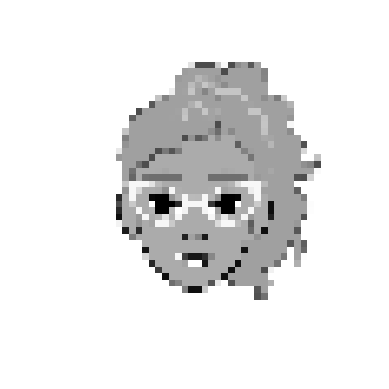

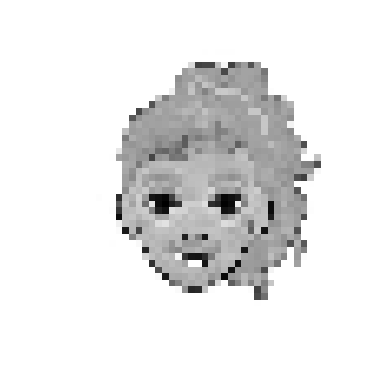

In [10]:
visualize.plot_img_original_generated(model=model,num_img=20,test_ds=test_ds)

In [21]:
visualize.plot_latent_images(model=model, num_images_x= 20, epoch=2, stan_des= 1, mean=0)

ValueError: Input 0 of layer "sequential_5" is incompatible with the layer: expected shape=(None, 90), found shape=(1, 2)